 1. import original data

In [361]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

df = pd.read_csv("/content/drive/My Drive/NCDB_2014.csv")  
print(df)
#check duplicates
df=df.drop_duplicates()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


        C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV  ... P_AGE P_PSN P_ISEV P_SAFE P_USER
0         2014      1      1     10      2  ...    75    11      2     NN      1
1         2014      1      1     12      2  ...    21    11      2     02      1
2         2014      1      1     00      2  ...    34    11      2     02      1
3         2014      1      1     17      2  ...    50    11      2     02      1
4         2014      1      1     17      2  ...    63    11      1     NN      1
...        ...    ...    ...    ...    ...  ...   ...   ...    ...    ...    ...
297607    2014     UU      U     UU      2  ...    24    11      1     NN      1
297608    2014     UU      U     23      2  ...    29    96      2     09      5
297609    2014     UU      U     14      2  ...    UU    11      2     01      1
297610    2014     UU      U     22      1  ...    67    12      3     01      U
297611    2014     UU      U     22      1  ...    10    98      1     01      U

[297612 rows x 22 columns]


In [362]:
#plot_confusion_matrix function
from itertools import product

def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    cmap = "coolwarm"
    im_ = ax.imshow(cm,interpolation = "nearest",cmap = "coolwarm")
    xlen, ylen = cm.shape
    thresh = (cm.max() + cm.min()) / xlen
    display_labels = (0,1)
    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)
    for i,j in product(range(xlen),range(xlen)):
        color = cmap_max if cm[i,j] < thresh else cmap_min
        ax.text(j,i,format(cm[i,j],".0f"),ha = "center",va = "center",color = "black")
    fig.colorbar(im_,ax = ax)
    ax.set(xticks = np.arange(xlen),
        yticks = np.arange(ylen),
        xticklabels = display_labels,
        yticklabels = display_labels,
        ylabel = "True label",
        xlabel = "Predicted label")
    ax.set_ylim((2 - 0.5,-0.5))
    plt.show()
    return None

In [363]:
# draw ROC curve function
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_roc_curve(test_y, probs):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(test_y))]
    # calculate scores
    ns_auc = roc_auc_score(test_y, ns_probs)
    auc = roc_auc_score(test_y, probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
    fpr, tpr, _ = roc_curve(test_y, probs)

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, linestyle='--', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.legend()
    # show the plot
    plt.show()

**1. government prodiction model**

In [524]:
#get needed factors from df
govdata=df[df.columns[df.columns.isin(['C_MNTH','C_WDAY','C_HOUR','C_VEHS','C_CONF','C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','C_SEV'])]]
govdata=govdata.drop_duplicates()
print(govdata)

       C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS  ... C_RCFG C_WTHR C_RSUR C_RALN C_TRAF
0           1      1     10      2      1  ...     03      1      3      2     18
1           1      1     12      2      1  ...     UU      1      5      1     UU
2           1      1     00      2      1  ...     UU      7      3      1     UU
3           1      1     17      2      2  ...     UU      1      1      1     18
5           1      1     22      2      1  ...     05      1      3      1     18
...       ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
297585     12      7     19      2     01  ...     01      1      3      4     18
297588     UU      U     UU      2     UU  ...     01      U      U      U     UU
297608     UU      U     23      2     01  ...     05      1      1      U     18
297609     UU      U     14      2     01  ...     01      1      5      4     18
297610     UU      U     22      1     01  ...     01      2      4      Q     18

[98772 rows x 1

1.1 data cleaning and processing

In [525]:
#check na
x =  govdata.isnull().sum().sum()
print(x)

0


In [526]:
#because Q,U,X cannot give info，thus replace with nan and then drop 
govdata = govdata.replace('Q',np.nan)
govdata = govdata.replace('U',np.nan)
govdata = govdata.replace('X',np.nan)
govdata = govdata.replace('QQ',np.nan)
govdata = govdata.replace('UU',np.nan)
govdata = govdata.replace('XX',np.nan)

In [527]:
govdata=govdata.dropna()

In [528]:
#turn string type into numeric
govdata=govdata.apply(pd.to_numeric,errors='ignore')

In [529]:
#check the dataset
print("info")
govdata.info()
print("describe")
print(govdata.describe().T)

info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69238 entries, 0 to 297585
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   C_MNTH  69238 non-null  int64
 1   C_WDAY  69238 non-null  int64
 2   C_HOUR  69238 non-null  int64
 3   C_SEV   69238 non-null  int64
 4   C_VEHS  69238 non-null  int64
 5   C_CONF  69238 non-null  int64
 6   C_RCFG  69238 non-null  int64
 7   C_WTHR  69238 non-null  int64
 8   C_RSUR  69238 non-null  int64
 9   C_RALN  69238 non-null  int64
 10  C_TRAF  69238 non-null  int64
dtypes: int64(11)
memory usage: 6.3 MB
describe
          count       mean        std  min  25%   50%   75%   max
C_MNTH  69238.0   6.626275   3.575225  1.0  3.0   7.0  10.0  12.0
C_WDAY  69238.0   3.912837   1.920397  1.0  2.0   4.0   5.0   7.0
C_HOUR  69238.0  13.286577   5.335521  0.0  9.0  14.0  17.0  23.0
C_SEV   69238.0   1.982105   0.132570  1.0  2.0   2.0   2.0   2.0
C_VEHS  69238.0   1.824605   0.836730  1.0  1.0   2.

In [530]:
#cut categorical variables into range
govdata['C_MONTH']=pd.cut(govdata['C_MNTH'],[-1,3,6,9,12],labels=['Q1','Q2','Q3','Q4'])
govdata['C_TIME']=pd.cut(govdata['C_HOUR'],[-1,3,7,11,15,19,23],labels=['[0,3]','[4,7]','[8,11]','[12,15]','[16,19]','[20,23]'])
govdata['C_CONFC']=pd.cut(govdata['C_CONF'],[-1,6,25,36,41],labels=['SingleVeh','TwoVehSame','TwoVehDif','TwoVehPar'])


In [531]:
#reselect the data column
govdata=govdata[govdata.columns[govdata.columns.isin(['C_MONTH','C_WDAY','C_TIME','C_CONFC','C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','C_SEV'])]]
print(govdata)

        C_WDAY  C_SEV  C_RCFG  C_WTHR  ...  C_TRAF  C_MONTH   C_TIME     C_CONFC
0            1      2       3       1  ...      18       Q1   [8,11]   SingleVeh
5            1      2       5       1  ...      18       Q1  [20,23]   SingleVeh
6            1      2       2       4  ...      16       Q1  [16,19]   TwoVehDif
8            1      2       2       1  ...      18       Q1  [12,15]   TwoVehDif
12           1      2       2       1  ...      18       Q1  [16,19]  TwoVehSame
...        ...    ...     ...     ...  ...     ...      ...      ...         ...
297576       7      2       3       2  ...      18       Q4  [20,23]   TwoVehDif
297579       7      2       1       2  ...      18       Q4    [0,3]   SingleVeh
297580       7      2       1       2  ...      18       Q4  [16,19]   SingleVeh
297582       7      2       1       1  ...      18       Q4  [12,15]   TwoVehPar
297585       7      2       1       1  ...      18       Q4  [16,19]   SingleVeh

[69238 rows x 10 columns]


In [532]:
#get dummy for categorical x variables
govdata= pd.get_dummies(govdata, columns = ['C_MONTH','C_WDAY','C_TIME','C_CONFC','C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF'], drop_first= True)
#swith y in 0 and 1
govdata.loc[govdata['C_SEV'] == 2,'C_SEV'] = 0

In [533]:
#check the imbalanced data problems
groups = govdata.groupby('C_SEV')
groups.size() 

C_SEV
0    67999
1     1239
dtype: int64

In [534]:
#under smapling
# Shuffle the Dataset.
shuffled_govdata = govdata.sample(frac=1,random_state=4)
# Put all the fraud class in a separate dataset.
fraud_govdata = shuffled_govdata.loc[shuffled_govdata['C_SEV'] == 1]
#random_state make sure generate the same result 
non_fraud_govdata=shuffled_govdata.loc[shuffled_govdata['C_SEV']== 0].sample(n=1239,random_state=42)
# Concatenate both dataframes again
normalized_govdata = pd.concat([fraud_govdata, non_fraud_govdata])
groups = normalized_govdata.groupby('C_SEV')
groups.size()  

C_SEV
0    1239
1    1239
dtype: int64

In [535]:
govdata=normalized_govdata
#spilt x and y
y=govdata[govdata.columns[govdata.columns.isin(['C_SEV'])]]
print(y)
X = govdata[govdata.columns[~govdata.columns.isin(['C_SEV'])]]
print(X)
#spilt train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020)

        C_SEV
254004      1
216366      1
94512       1
121761      1
90220       1
...       ...
250450      0
207868      0
150641      0
164719      0
14745       0

[2478 rows x 1 columns]
        C_MONTH_Q2  C_MONTH_Q3  C_MONTH_Q4  ...  C_TRAF_16  C_TRAF_17  C_TRAF_18
254004           0           0           1  ...          0          0          1
216366           0           1           0  ...          0          0          0
94512            1           0           0  ...          0          0          1
121761           1           0           0  ...          0          0          1
90220            1           0           0  ...          0          0          1
...            ...         ...         ...  ...        ...        ...        ...
250450           0           0           1  ...          0          0          1
207868           0           1           0  ...          0          0          0
150641           0           1           0  ...          0          0         

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression
[[703 290]
 [318 671]]
Regression TrainSet: Accurarcy 69.32%
[[175  71]
 [ 71 179]]
Regression Testset: Accurarcy 71.37%
Confusion matrix:


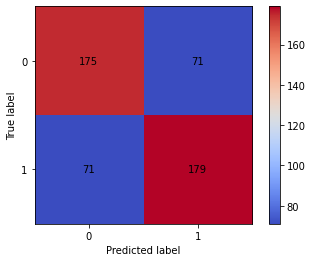

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       246
           1       0.72      0.72      0.72       250

    accuracy                           0.71       496
   macro avg       0.71      0.71      0.71       496
weighted avg       0.71      0.71      0.71       496

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.714


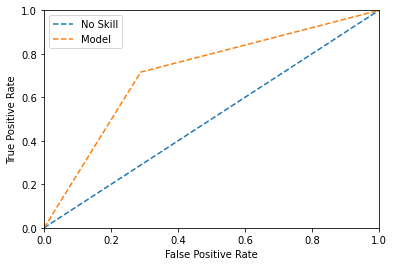

In [477]:
#Model 1 : linear regression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
#intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', 
#verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

linear_classifier = linear_model.LogisticRegression(random_state=123)
linear_classifier.fit(X_train, y_train)
y_pred_train1 = linear_classifier.predict(X_train)
cm1_train = confusion_matrix(y_train,y_pred_train1)
print("Regression")
print("================================")
print(cm1_train)
acc_train1 = (cm1_train[0,0] + cm1_train[1,1]) / sum(sum(cm1_train))
print("Regression TrainSet: Accurarcy %.2f%%" % (acc_train1*100))
print("================================")
y_pred1 = linear_classifier.predict(X_test)
cm1 = confusion_matrix(y_test,y_pred1)
print(cm1)
acc1 = (cm1[0,0] + cm1[1,1]) / sum(sum(cm1))
print("Regression Testset: Accurarcy %.2f%%" % (acc1*100))
print("================================")
print("================================")
print("================================")

#evaluate the result
print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(y_test,y_pred1))
print("Classification report:")
print(classification_report(y_test,y_pred1))
plot_roc_curve(y_test,y_pred1)

Text(0.5, 1.0, 'Variances Importances')

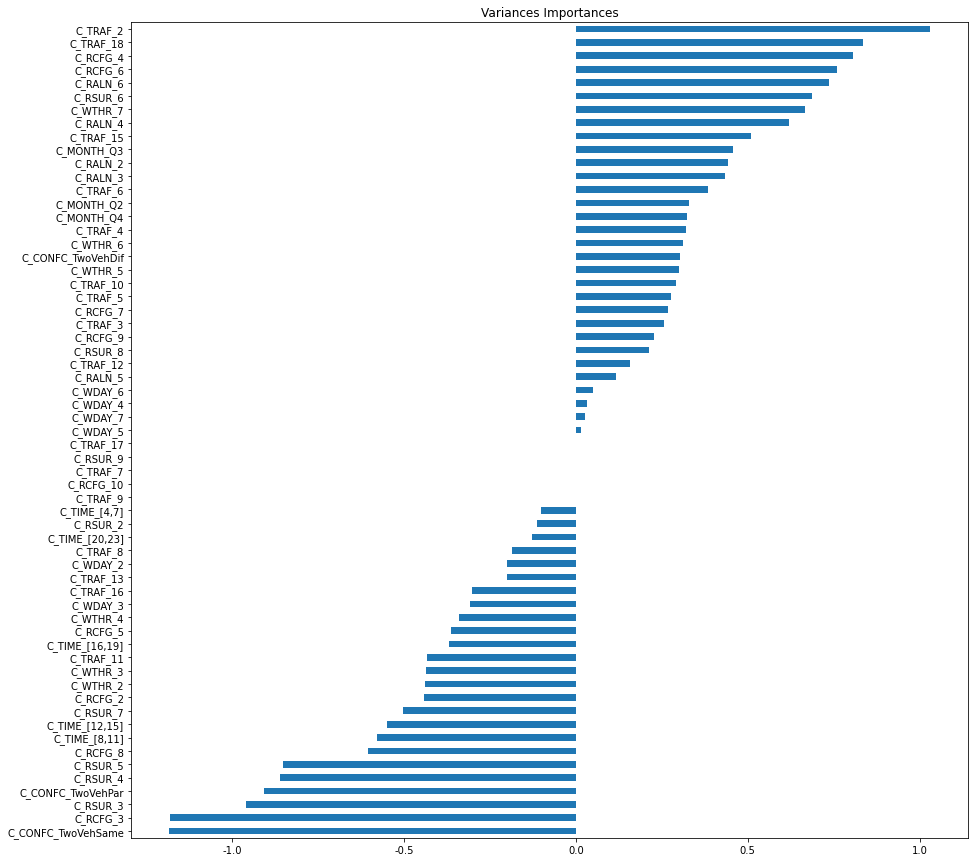

In [380]:
#plot the variable importance
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 

coef_LR = pd.Series(modelLR.coef_.flatten(),index = X_test.columns,name = 'Var')

plt.figure(figsize=(15,15))
coef_LR.sort_values().plot(kind='barh')
plt.title("Variances Importances")

In [479]:
#Model 2: decision tree
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, 
#min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
#min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred_train2 = clf.predict(X_train)
cm2_train = confusion_matrix(y_train,y_pred_train2)
print("Decision Tree")
print("================================")
#print(cm2_train)
acc_train2 = (cm2_train[0,0] + cm2_train[1,1]) / sum(sum(cm2_train))
print("Decsion Tree TrainSet: Accurarcy %.2f%%" % (acc_train2*100))
print("================================")
y_pred2 = clf.predict(X_test)
#cm2 = confusion_matrix(y_test,y_pred2)
acc2 = (cm2[0,0] + cm2[1,1]) / sum(sum(cm2))
#print(cm2)
print("Decision Tree Testset: Accurarcy %.2f%%" % (acc2*100))
print("================================")
print("================================")
print("================================")



#children_right = clf.tree_.children_right
#feature = clf.tree_.feature   ### At node i, which column am I using
#threshold = clf.tree_.threshold ### At node i, which is the threshold
#print(n_nodes)
#print(children_left)
#print(children_right)
#print(feature)
#tree.plot_tree(clf)

Decision Tree
Decsion Tree TrainSet: Accurarcy 95.41%
Decision Tree Testset: Accurarcy 70.62%


Number of nodes in the last tree is: 1 with ccp_alpha: 0.029443998308354924


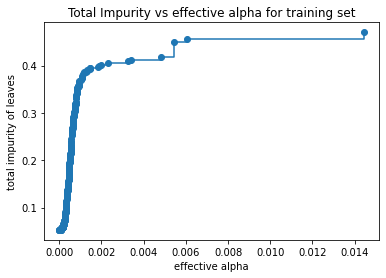

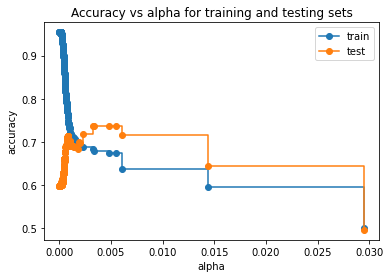

My highest validation accuracy: 0.7379


In [480]:
#prune the tree
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))


train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()


print('My highest validation accuracy: {:.4f}'.format(max(test_scores)))


n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left 


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.714


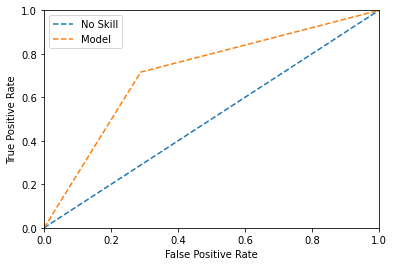

Confusion matrix:


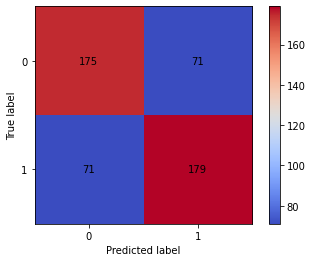

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       246
           1       0.72      0.72      0.72       250

    accuracy                           0.71       496
   macro avg       0.71      0.71      0.71       496
weighted avg       0.71      0.71      0.71       496



In [481]:
#evaluate the result
plot_roc_curve(y_test,y_pred1)
print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(y_test,y_pred1))
print("Classification report:")
print(classification_report(y_test,y_pred1))

Epoch 1/100
100/100 [==============================] - 0s 922us/step - loss: 0.6868 - accuracy: 0.5535
Epoch 2/100
100/100 [==============================] - 0s 942us/step - loss: 0.6791 - accuracy: 0.6019
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6728 - accuracy: 0.6085
Epoch 4/100
100/100 [==============================] - 0s 966us/step - loss: 0.6667 - accuracy: 0.6181
Epoch 5/100
100/100 [==============================] - 0s 894us/step - loss: 0.6605 - accuracy: 0.6261
Epoch 6/100
100/100 [==============================] - 0s 895us/step - loss: 0.6546 - accuracy: 0.6332
Epoch 7/100
100/100 [==============================] - 0s 920us/step - loss: 0.6488 - accuracy: 0.6347
Epoch 8/100
100/100 [==============================] - 0s 946us/step - loss: 0.6431 - accuracy: 0.6387
Epoch 9/100
100/100 [==============================] - 0s 893us/step - loss: 0.6380 - accuracy: 0.6448
Epoch 10/100
100/100 [==============================] - 0s 1ms/step - loss:

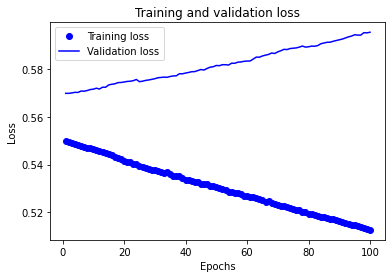

Confusion matrix:


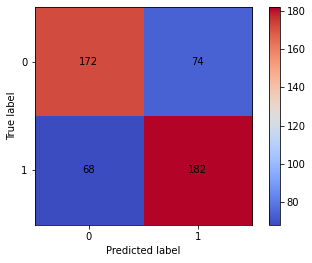

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       246
           1       0.71      0.73      0.72       250

    accuracy                           0.71       496
   macro avg       0.71      0.71      0.71       496
weighted avg       0.71      0.71      0.71       496

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.714


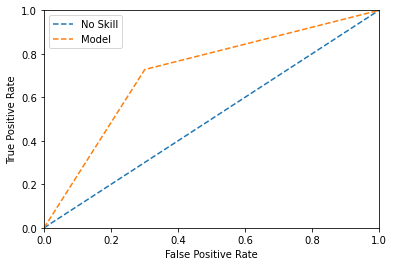

In [537]:
#Model 5: neural network
#https://www.tensorflow.org/guide/keras/train_and_evaluate
from keras.datasets import imdb
import numpy as np
from keras import models
from keras import layers
import matplotlib.pyplot as plt


model = Sequential()
#input_dim=column-1
model.add(Dense(10, input_dim=61, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile mode
# https://www.tensorflow.org/guide/keras/train_and_evaluate

model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=20)
# evaluate the model
scores = model.evaluate(X_train, y_train)
#print(scores)
print("Neural Network Trainset: \n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# evaluate the model
scores = model.evaluate(X_test, y_test)
print(scores)
print("Keras: \n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

predictions = model.predict(X_test)
print(predictions)
print('predictions shape:', predictions.shape)

y_pred = (predictions > 0.5)
y_pred=y_pred*1 #convert to 0,1 instead of True False
matrix = confusion_matrix(y_test, y_pred)
print(matrix)


history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test,y_test))
history_dict = history.history
history_dict.keys()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))


#evaluate the result
plot_roc_curve(y_test,y_pred)

 3. insurance company model

In [495]:
#select variables for PISEV
insur_data=df[df.columns[df.columns.isin(['C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SEX','P_AGE','P_PSN','P_SAFE','P_USER','P_ISEV'])]]
print(insur_data)

       C_RCFG C_WTHR C_RSUR C_RALN C_TRAF  ... P_AGE P_PSN P_ISEV P_SAFE P_USER
0          03      1      3      2     18  ...    75    11      2     NN      1
1          UU      1      5      1     UU  ...    21    11      2     02      1
2          UU      7      3      1     UU  ...    34    11      2     02      1
3          UU      1      1      1     18  ...    50    11      2     02      1
4          UU      1      1      1     18  ...    63    11      1     NN      1
...       ...    ...    ...    ...    ...  ...   ...   ...    ...    ...    ...
297607     01      U      U      U     UU  ...    24    11      1     NN      1
297608     05      1      1      U     18  ...    29    96      2     09      5
297609     01      1      5      4     18  ...    UU    11      2     01      1
297610     01      2      4      Q     18  ...    67    12      3     01      U
297611     01      2      4      Q     18  ...    10    98      1     01      U

[297452 rows x 12 columns]


In [496]:
#check na
x =  insur_data.isnull().sum().sum()
print(x)

0


In [497]:
#The model is for person, thus replace with NAN in VTYPE and VYEAR, then fill in with adjacent methods
insur_data.loc[insur_data['V_TYPE'] =='NN','V_TYPE'] = np.nan
insur_data.loc[insur_data['V_TYPE'] =='QQ','V_TYPE'] = np.nan
insur_data.loc[insur_data['V_TYPE'] =='UU','V_TYPE'] = np.nan
insur_data.loc[insur_data['P_USER'] =='U','P_USER'] = np.nan
insur_data = insur_data.replace('X',np.nan)
insur_data = insur_data.replace('XX',np.nan)
insur_data = insur_data.replace('QQ',np.nan)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid d

In [498]:
#Use the value in front of the missing value of each column to fill (fill according to the corresponding column, fill before and after the corresponding index)
insur_data.fillna(method='ffill',inplace=True)
insur_data.fillna(method='pad',inplace=True)
#Use the value behind the missing value of each column to fill (fill according to the corresponding column, fill before and after the corresponding index)
insur_data.fillna(method='backfill',inplace=True)
insur_data.fillna(method='bfill',inplace=True)

In [499]:
#The remained irrevalent can drop the row directly
insur_data = insur_data.replace('N',np.nan)
insur_data = insur_data.replace('NN',np.nan)
insur_data = insur_data.replace('U',np.nan)
insur_data = insur_data.replace('UU',np.nan)
insur_data = insur_data.replace('Q',np.nan)
insur_data=insur_data.dropna()

In [500]:
#Use the value in front of the missing value of each column to fill (fill according to the corresponding column, fill before and after the corresponding index)
insur_data.fillna(method='ffill',inplace=True)
insur_data.fillna(method='pad',inplace=True)
#Use the value behind the missing value of each column to fill (fill according to the corresponding column, fill before and after the corresponding index)
insur_data.fillna(method='backfill',inplace=True)
insur_data.fillna(method='bfill',inplace=True)

In [501]:
#switch string into numeric
insur_data=insur_data.apply(pd.to_numeric,errors='ignore')

In [502]:
#cut category variables into range
insur_data['P_AGEGR']=pd.cut(insur_data['P_AGE'],[0,17,34,51,68,85,99],labels=['(0,17]','(17,34]','(34,51]','(51,68]','(68,85]','(85,99]'])
insur_data['P_PSNGR']=pd.cut(insur_data['P_PSN'],[0,11,13,23,33,96,98,99],labels=['driver','front','second','third','others','out','Pedestrian'])
insur_data=insur_data[insur_data.columns[insur_data.columns.isin(['C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SEX','P_AGEGR','P_PSNGR','P_SAFE','P_USER','P_ISEV'])]]
print(insur_data)

        C_RCFG  C_WTHR  C_RSUR  C_RALN  ...  P_SAFE  P_USER  P_AGEGR  P_PSNGR
5            5       1       3       1  ...       2       1  (17,34]   driver
6            2       4       3       4  ...       2       1  (17,34]   driver
7            2       4       3       4  ...       2       1  (17,34]   driver
8            2       1       1       1  ...       2       1  (68,85]   driver
13           2       1       4       1  ...       2       1  (17,34]   driver
...        ...     ...     ...     ...  ...     ...     ...      ...      ...
297583       1       1       5       1  ...       2       1  (34,51]   driver
297584       1       1       5       1  ...       2       2  (17,34]    front
297585       1       1       3       4  ...       2       1  (34,51]   driver
297586       1       1       3       4  ...       2       2  (17,34]    front
297587       1       1       3       4  ...       2       2   (0,17]   second

[194578 rows x 12 columns]


In [503]:
#check the imbalanced data problems
groups = insur_data.groupby('P_ISEV')
groups.size() 

P_ISEV
1     81068
2    112345
3      1165
dtype: int64

In [504]:
#under-sampling 
# Shuffle the Dataset.
shuffled_insur_data = insur_data.sample(frac=1,random_state=4)
# Put all the fraud class in a separate dataset.
fraud_insur_data = shuffled_insur_data.loc[shuffled_insur_data['P_ISEV'] == 3]
non_fraud_insur_data=shuffled_insur_data.loc[shuffled_insur_data['P_ISEV']==2].sample(n=616,random_state=42)
non_fraud_insur_data1=shuffled_insur_data.loc[shuffled_insur_data['P_ISEV']==1].sample(n=616,random_state=42)
# Concatenate both dataframes again
normalized_insur_data = pd.concat([fraud_insur_data,non_fraud_insur_data])
normalized_insur_data = pd.concat([normalized_insur_data,non_fraud_insur_data1])
groups = normalized_insur_data.groupby('P_ISEV')
groups.size() 
insur_data=normalized_insur_data

In [505]:
#get dummy for categorical x variables
insur_data= pd.get_dummies(insur_data, columns = ['C_RCFG','C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SEX','P_AGEGR','P_PSNGR','P_SAFE','P_USER'], drop_first= True)
#switch y into 0 and 1
insur_data.loc[insur_data['P_ISEV'] == 1,'P_ISEV'] = 0
insur_data.loc[insur_data['P_ISEV'] == 2,'P_ISEV'] = 0
insur_data.loc[insur_data['P_ISEV'] == 3,'P_ISEV'] = 1
groups = insur_data.groupby('P_ISEV')
print(insur_data)

        P_ISEV  C_RCFG_2  C_RCFG_3  ...  P_USER_3  P_USER_4  P_USER_5
209095       1         1         0  ...         0         0         1
45809        1         0         0  ...         0         0         0
187061       1         0         0  ...         0         0         0
59727        1         0         0  ...         0         0         0
128902       1         1         0  ...         0         1         0
...        ...       ...       ...  ...       ...       ...       ...
197576       0         1         0  ...         0         0         0
141369       0         1         0  ...         0         0         0
208562       0         1         0  ...         0         0         0
215285       0         1         0  ...         0         0         0
266430       0         1         0  ...         0         0         0

[2397 rows x 71 columns]


In [506]:
#set x and y
y=insur_data[insur_data.columns[insur_data.columns.isin(['P_ISEV'])]]
print(y)
X = insur_data[insur_data.columns[~insur_data.columns.isin(['P_ISEV'])]]
print(X)
#spilt train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020)

        P_ISEV
209095       1
45809        1
187061       1
59727        1
128902       1
...        ...
197576       0
141369       0
208562       0
215285       0
266430       0

[2397 rows x 1 columns]
        C_RCFG_2  C_RCFG_3  C_RCFG_4  ...  P_USER_3  P_USER_4  P_USER_5
209095         1         0         0  ...         0         0         1
45809          0         0         0  ...         0         0         0
187061         0         0         0  ...         0         0         0
59727          0         0         0  ...         0         0         0
128902         1         0         0  ...         0         1         0
...          ...       ...       ...  ...       ...       ...       ...
197576         1         0         0  ...         0         0         0
141369         1         0         0  ...         0         0         0
208562         1         0         0  ...         0         0         0
215285         1         0         0  ...         0         0         0
266

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression
[[781 212]
 [254 670]]
Regression TrainSet: Accurarcy 75.69%
[[189  50]
 [ 63 178]]
Regression Testset: Accurarcy 76.46%
Confusion matrix:


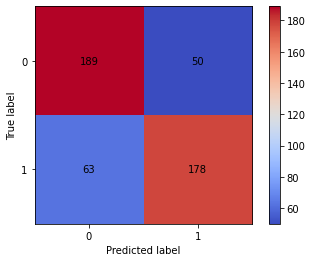

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       239
           1       0.78      0.74      0.76       241

    accuracy                           0.76       480
   macro avg       0.77      0.76      0.76       480
weighted avg       0.77      0.76      0.76       480

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.765


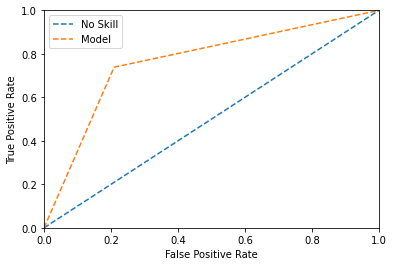

In [507]:
#Model 1 : linear regression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
#intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', 
#verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

linear_classifier = linear_model.LogisticRegression(random_state=123)
linear_classifier.fit(X_train, y_train)
y_pred_train1 = linear_classifier.predict(X_train)
cm1_train = confusion_matrix(y_train,y_pred_train1)
print("Regression")
print("================================")
print(cm1_train)
acc_train1 = (cm1_train[0,0] + cm1_train[1,1]) / sum(sum(cm1_train))
print("Regression TrainSet: Accurarcy %.2f%%" % (acc_train1*100))
print("================================")
y_pred1 = linear_classifier.predict(X_test)
cm1 = confusion_matrix(y_test,y_pred1)
print(cm1)
acc1 = (cm1[0,0] + cm1[1,1]) / sum(sum(cm1))
print("Regression Testset: Accurarcy %.2f%%" % (acc1*100))
print("================================")
print("================================")
print("================================")

#evaluate the result
print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(y_test,y_pred1))
print("Classification report:")
print(classification_report(y_test,y_pred1))


plot_roc_curve(y_test,y_pred1)

Text(0.5, 1.0, 'Variances Importances')

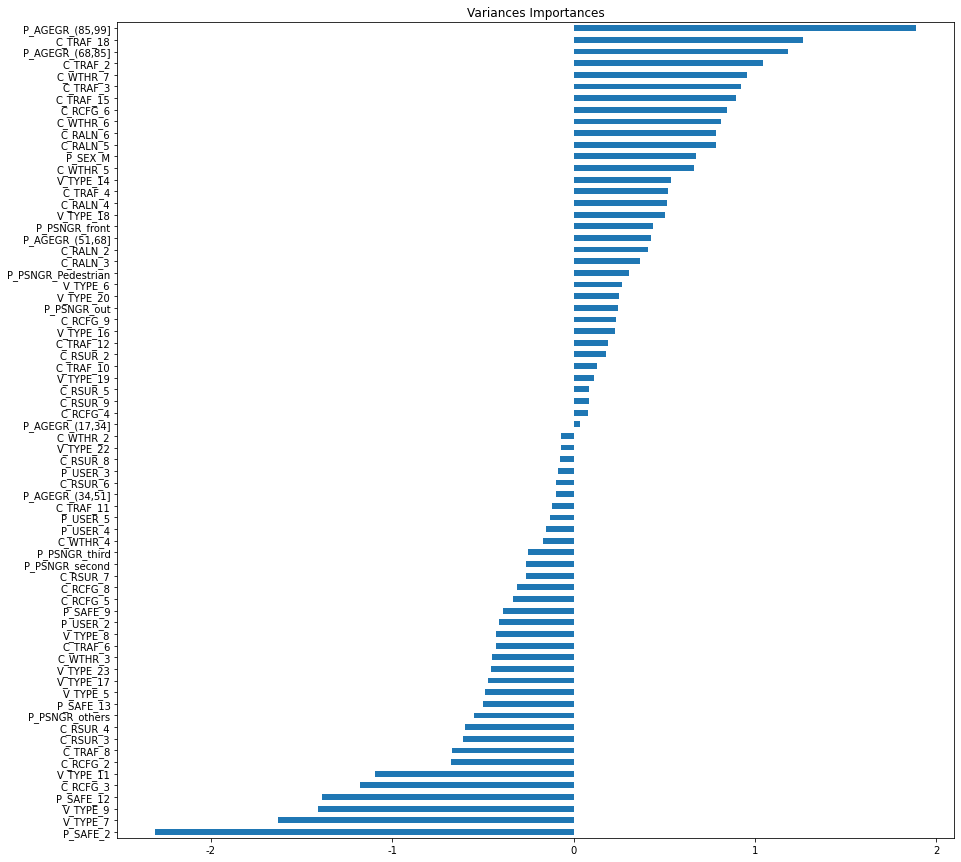

In [508]:
#plot variable importance
#plot the variable importance
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 

coef_LR = pd.Series(linear_classifier.coef_.flatten(),index = X_test.columns,name = 'Var')

plt.figure(figsize=(15,15))
coef_LR.sort_values().plot(kind='barh')
plt.title("Variances Importances")

In [509]:
from sklearn.tree import DecisionTreeClassifier

path = DecisionTreeClassifier(criterion = "gini",random_state = 2020).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print("Cost complexity pruning alphas:")
print(ccp_alphas)

Cost complexity pruning alphas:
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.25821822e-06 3.16150551e-06 4.96808009e-06 6.68780012e-06
 7.17967703e-06 7.45212013e-06 8.02536014e-06 9.44160016e-06
 1.24202002e-05 1.44902336e-05 1.49042403e-05 1.63654403e-05
 1.86303003e-05 1.88832003e-05 1.88832003e-05 1.93203114e-05
 1.95561304e-05 2.07003337e-05 2.10767034e-05 2.12436004e-05
 2.41142194e-05 2.48404004e-05 2.52920441e-05 2.58401689e-05
 2.60824204e-05 2.60824204e-05 2.60824204e-05 2.68727968e-05
 3.00951005e-05 3.13553442e-05 3.15619205e-05 3.47765606e-05
 3.47765606e-05 3.47765606e-05 3.92350940e-05 4.02414487e-05
 4.18364639e-05 4.34707007e-05 4.34707007e-05 4.81521608e-05
 4.96808009e-05 5.21648409e-05 5.21648409e-05 5.21648409e-05
 5.40008705e-05 5.58909010e-05 5.79609343e-05 5.79609343e-05
 5.79609343e-05 5.96169610e-05 6.32301102e-05 6.62410678e-05
 6.95531212e-05 6.95531212e-05 7.06749457e-05 7.07084887e-05
 8.69414015e-05 8.69414015e-05 9.07214624e-05 9.93616

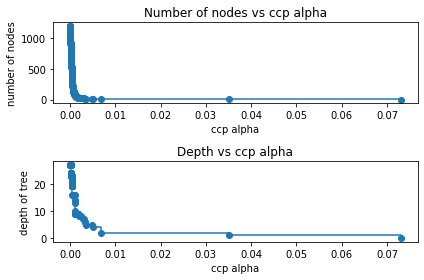

In [510]:
paths = []
for ccp_alpha in ccp_alphas:
    path = DecisionTreeClassifier(criterion = "gini",random_state = 2020,ccp_alpha = ccp_alpha)
    path.fit(X_train, y_train)
    paths.append(path)

node_counts = [path.tree_.node_count for path in paths]
depth = [path.tree_.max_depth for path in paths]
fig, ax = plt.subplots(2,1)
ax[0].plot(ccp_alphas,node_counts,marker = "o",drawstyle = "steps-post")
ax[0].set_xlabel("ccp alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs ccp alpha")
ax[1].plot(ccp_alphas,depth,marker = "o",drawstyle = "steps-post")
ax[1].set_xlabel("ccp alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs ccp alpha")
fig.tight_layout();
plt.show()

Optimal cost complexity pruning alpha: 0.0008303529703698494
Minimum average cross validation error: 0.25665357766143104



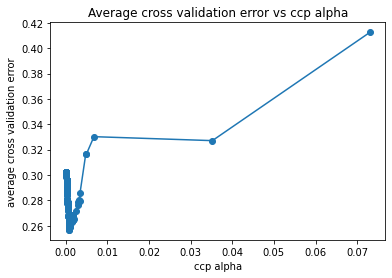

In [511]:
from sklearn.model_selection import cross_val_score

parameter_scores = []
for ccp_alpha in ccp_alphas:
    decision_tree_model_cv = DecisionTreeClassifier(criterion = "gini",random_state = 2020,ccp_alpha = ccp_alpha)
    scores = 1 - cross_val_score(decision_tree_model_cv,X_train, y_train,cv = 10,scoring = "accuracy") 
    parameter_scores.append(scores.mean())
cross_validation_score_optimal = min(parameter_scores)
optimal_parameter = ccp_alphas[parameter_scores.index(min(parameter_scores))]
print("Optimal cost complexity pruning alpha:",optimal_parameter)
print("Minimum average cross validation error:",cross_validation_score_optimal)
print()
plt.plot(ccp_alphas,parameter_scores,marker = "o")
plt.xlabel("ccp alpha")
plt.ylabel("average cross validation error")
plt.title("Average cross validation error vs ccp alpha")
plt.show()

Confusion matrix:


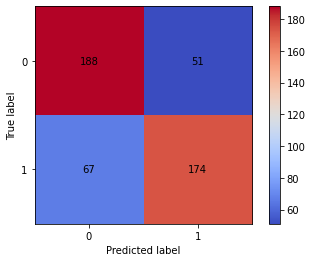

Accuracy:
75.42%

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       239
           1       0.77      0.72      0.75       241

    accuracy                           0.75       480
   macro avg       0.76      0.75      0.75       480
weighted avg       0.76      0.75      0.75       480

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.765


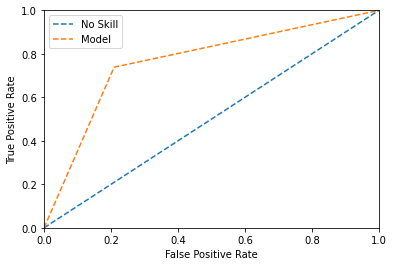

In [462]:
pruned_decision_tree = DecisionTreeClassifier(criterion = "gini",random_state = 2020,ccp_alpha = optimal_parameter)
pruned_decision_tree.fit(X_train, y_train)
pred_pruned_tree = pruned_decision_tree.predict(X_test)

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(y_test,pred_pruned_tree,labels = [0,1]))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(y_test,pred_pruned_tree) * 100))
print()
print("Classification report:")
print(classification_report(y_test,pred_pruned_tree))

#evaluate the result
plot_roc_curve(y_test,y_pred1)


Epoch 1/100
30/30 [==============================] - 0s 2ms/step - loss: 0.6706 - auc: 0.6649
Epoch 2/100
30/30 [==============================] - 0s 1ms/step - loss: 0.6505 - auc: 0.7159
Epoch 3/100
30/30 [==============================] - 0s 1ms/step - loss: 0.6285 - auc: 0.7375
Epoch 4/100
30/30 [==============================] - 0s 1ms/step - loss: 0.6069 - auc: 0.7571
Epoch 5/100
30/30 [==============================] - 0s 1ms/step - loss: 0.5806 - auc: 0.7785
Epoch 6/100
30/30 [==============================] - 0s 1ms/step - loss: 0.5767 - auc: 0.7747
Epoch 7/100
30/30 [==============================] - 0s 1ms/step - loss: 0.5592 - auc: 0.7928
Epoch 8/100
30/30 [==============================] - 0s 1ms/step - loss: 0.5511 - auc: 0.7966
Epoch 9/100
30/30 [==============================] - 0s 1ms/step - loss: 0.5444 - auc: 0.8006
Epoch 10/100
30/30 [==============================] - 0s 1ms/step - loss: 0.5471 - auc: 0.7994
Epoch 11/100
30/30 [==============================] - 0s 1m

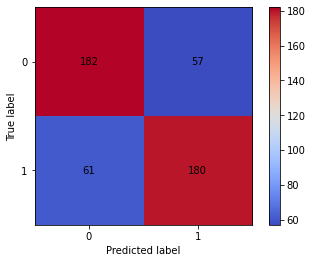

Accuracy:
75.42%
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       239
           1       0.76      0.75      0.75       241

    accuracy                           0.75       480
   macro avg       0.75      0.75      0.75       480
weighted avg       0.75      0.75      0.75       480

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.828


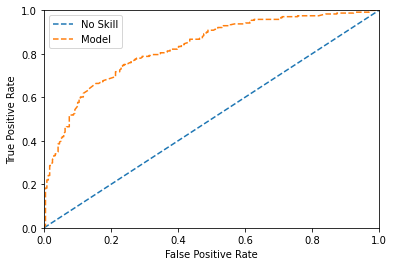

In [463]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from numpy.random import seed
from tensorflow.random import set_seed
seed(0)
set_seed(0)


model = Sequential()
model.add(Dense(12, kernel_initializer = 'he_uniform',activation='relu',input_dim = 70))
model.add(Dropout(0.1))
model.add(Dense(6, kernel_initializer = 'he_uniform',activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['AUC'])
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size = 64)
# evaluate the model

predictions = model.predict(X_test)

print("Confusion matrix:")
plot_confusion_matrix(confusion_matrix(y_test,(predictions > 0.5)*1))
print("Accuracy:")
print("{0:.2f}%".format(accuracy_score(y_test,(predictions > 0.5)*1) * 100))
print("Classification report:")
print(classification_report(y_test,(predictions > 0.5)*1))

#evaluate the result
plot_roc_curve(y_test, predictions)